Customer Churn Prediction with Random Forest

This project predicts customer churn using a Random Forest Classifier on the customerChurnDataset.csv dataset. The pipeline includes data cleaning, one-hot encoding, model training with class weighting, evaluation, and in-depth visualizations for exploratory data analysis (EDA) and model performance. The visualizations are designed to provide deep insights into the data and model, making the project ideal for GitHub presentation.

1. Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import joblib
%matplotlib inline

2. Loading and Inspecting Data

In [2]:
df = pd.read_csv('customerChurnDataset.csv')
print(df.head())
print(df.info())
print(df.describe())

   CustomerID   Age  Gender  Tenure  Usage Frequency  Support Calls  \
0         2.0  30.0  Female    39.0             14.0            5.0   
1         3.0  65.0  Female    49.0              1.0           10.0   
2         4.0  55.0  Female    14.0              4.0            6.0   
3         5.0  58.0    Male    38.0             21.0            7.0   
4         6.0  23.0    Male    32.0             20.0            5.0   

   Payment Delay Subscription Type Contract Length  Total Spend  \
0           18.0          Standard          Annual        932.0   
1            8.0             Basic         Monthly        557.0   
2           18.0             Basic       Quarterly        185.0   
3            7.0          Standard         Monthly        396.0   
4            8.0             Basic         Monthly        617.0   

   Last Interaction  Churn  
0              17.0    1.0  
1               6.0    1.0  
2               3.0    1.0  
3              29.0    1.0  
4              20.0    1.

3. Data Cleaning



In [3]:
df = df.drop(columns=['Subscription Type', 'CustomerID', 'Usage Frequency', 'Tenure', 'Total Spend'])
df = df.dropna()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Age               440832 non-null  float64
 1   Gender            440832 non-null  object 
 2   Support Calls     440832 non-null  float64
 3   Payment Delay     440832 non-null  float64
 4   Contract Length   440832 non-null  object 
 5   Last Interaction  440832 non-null  float64
 6   Churn             440832 non-null  float64
dtypes: float64(5), object(2)
memory usage: 26.9+ MB
None


4. Exploratory Data Analysis (EDA)

4.1 Class Distribution

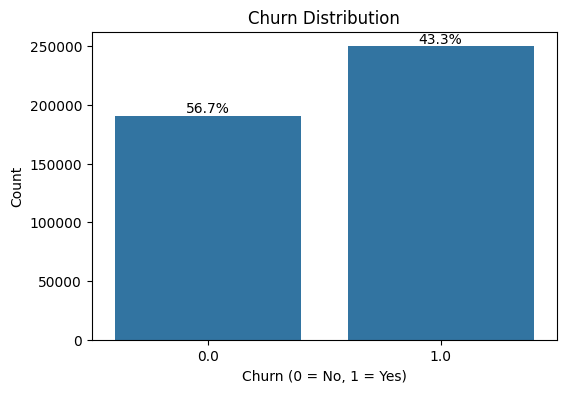

Churn
1.0    0.567107
0.0    0.432893
Name: proportion, dtype: float64


In [4]:
churn_counts = df['Churn'].value_counts(normalize=True) * 100
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Count')
for i, p in enumerate(ax.patches):
    percentage = f'{churn_counts.iloc[i]:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')
plt.savefig('churn_distribution.png')
plt.show()
print(df['Churn'].value_counts(normalize=True))

4.2 Age Distribution by Churn

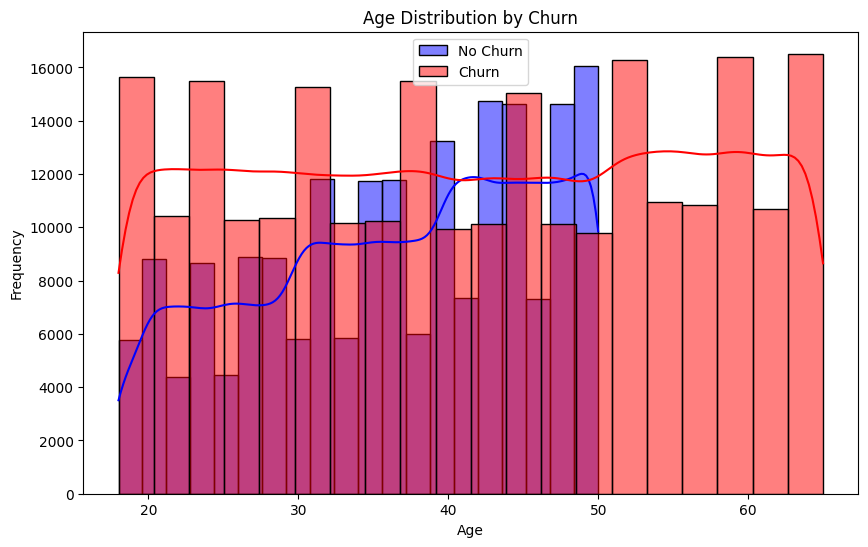

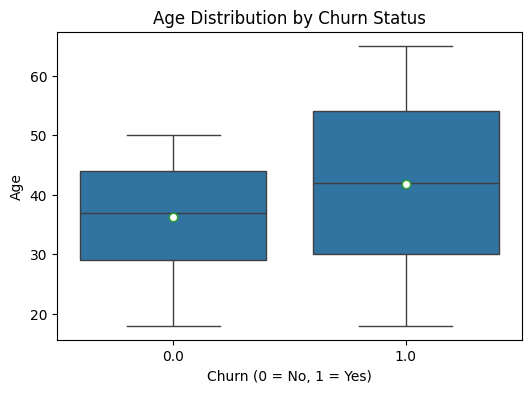

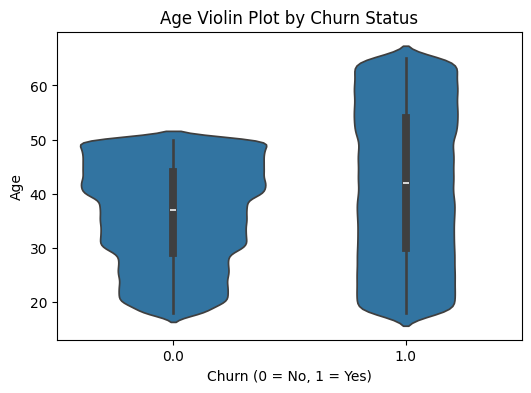

In [5]:
# Histogram with KDE
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Churn'] == 0]['Age'], kde=True, color='blue', label='No Churn', bins=20)
sns.histplot(df[df['Churn'] == 1]['Age'], kde=True, color='red', label='Churn', bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution by Churn')
plt.legend()
plt.savefig('age_distribution.png')
plt.show()

# Box Plot
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='Churn', y='Age', showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white"})
plt.title('Age Distribution by Churn Status')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Age')
plt.savefig('age_boxplot.png')
plt.show()

# Violin Plot
plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x='Churn', y='Age')
plt.title('Age Violin Plot by Churn Status')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Age')
plt.savefig('age_violinplot.png')
plt.show()

4.3 Categorical Feature Analysis

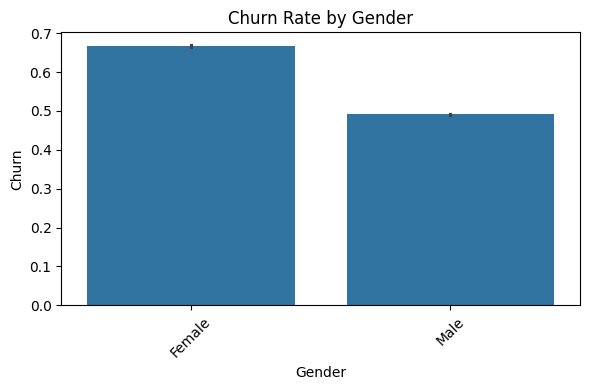

<Figure size 600x400 with 0 Axes>

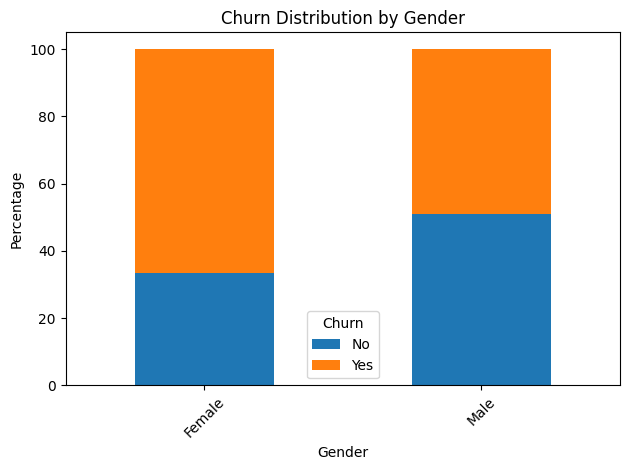

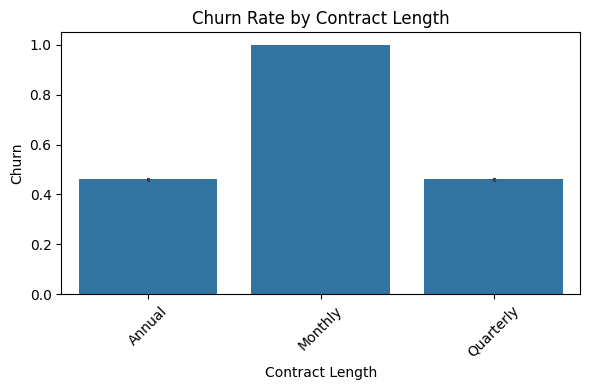

<Figure size 600x400 with 0 Axes>

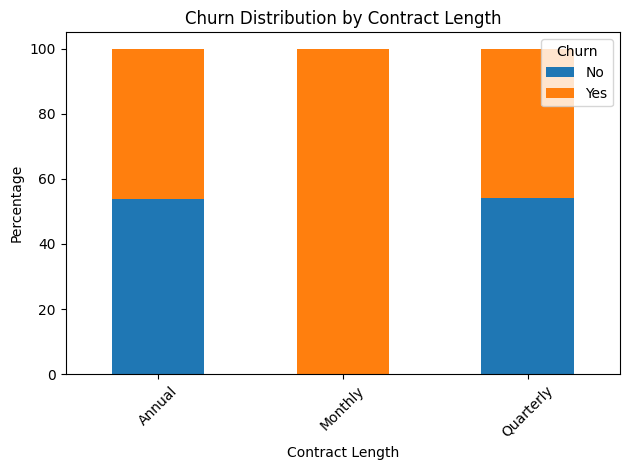

In [6]:
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    # Bar Plot for Churn Rate
    plt.figure(figsize=(6, 4))
    sns.barplot(x=col, y='Churn', data=df)
    plt.title(f'Churn Rate by {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'churn_rate_by_{col.lower().replace(" ", "_")}.png')
    plt.show()

    # Stacked Bar Plot
    plt.figure(figsize=(6, 4))
    churn_cross = pd.crosstab(df[col], df['Churn'], normalize='index') * 100
    churn_cross.plot(kind='bar', stacked=True)
    plt.title(f'Churn Distribution by {col}')
    plt.xlabel(col)
    plt.ylabel('Percentage')
    plt.legend(title='Churn', labels=['No', 'Yes'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'stacked_churn_by_{col.lower().replace(" ", "_")}.png')
    plt.show()

4.4 Pair Plot for Numerical Features

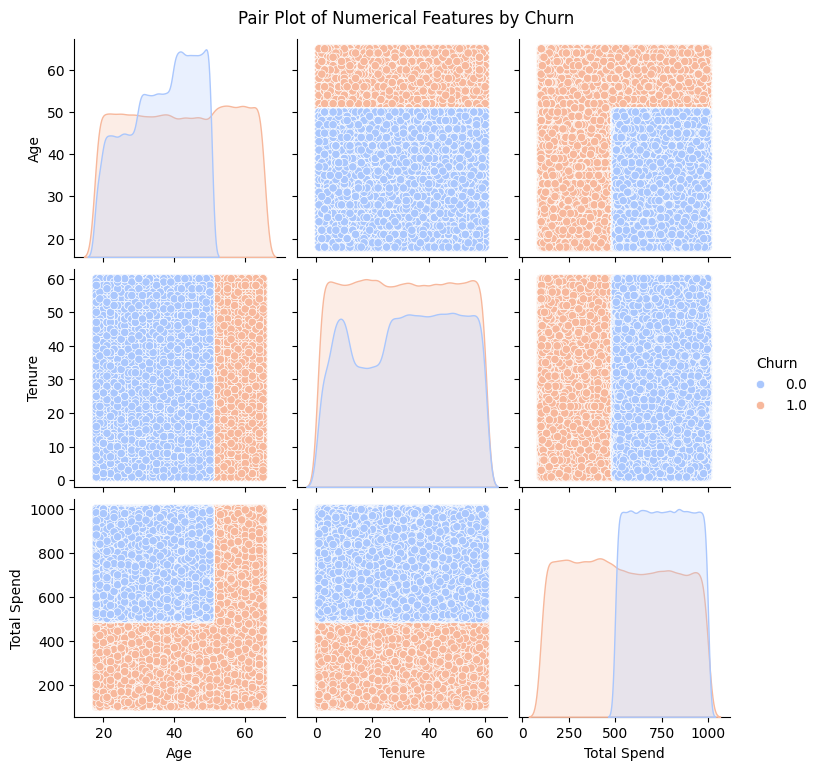

In [7]:
# Reload dataset to include numerical columns for EDA
df_full = pd.read_csv('customerChurnDataset.csv')
numerical_cols = ['Age', 'Tenure', 'Total Spend']
sns.pairplot(df_full[numerical_cols + ['Churn']], hue='Churn', palette='coolwarm')
plt.suptitle('Pair Plot of Numerical Features by Churn', y=1.02)
plt.savefig('pair_plot.png')
plt.show()

4.5 Correlation Heatmap

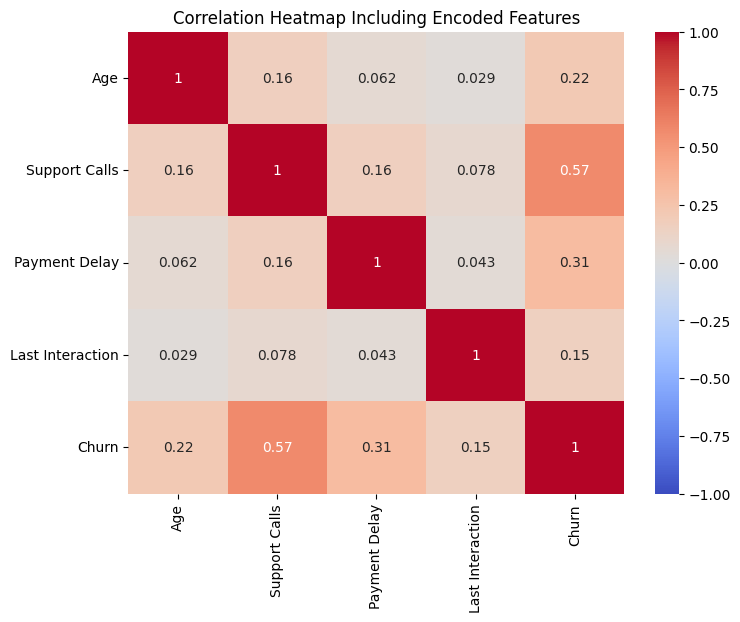

In [8]:
# Encode categorical features for correlation
df_encoded = pd.get_dummies(df, columns=['Gender', 'Contract Length'], drop_first=True)
numeric_df = df_encoded.select_dtypes(include='number')
corr = numeric_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap Including Encoded Features')
plt.savefig('correlation_heatmap.png')
plt.show()

5. Feature Encoding

In [9]:
x = df.drop(columns='Churn')
y = df['Churn']
x_encoded = pd.get_dummies(x, drop_first=True)
print(x_encoded.columns)

Index(['Age', 'Support Calls', 'Payment Delay', 'Last Interaction',
       'Gender_Male', 'Contract Length_Monthly', 'Contract Length_Quarterly'],
      dtype='object')


6. Splitting Data

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, random_state=1)
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (352665, 7)
Shape of y_train: (352665,)
Shape of x_test: (88167, 7)
Shape of y_test: (88167,)


7. Training the Random Forest Model

In [11]:
best_rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=1,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=100
)
best_rf.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, random_state=1)

8. Model Evaluation


Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     38091
         1.0       1.00      0.96      0.98     50076

    accuracy                           0.98     88167
   macro avg       0.97      0.98      0.98     88167
weighted avg       0.98      0.98      0.98     88167



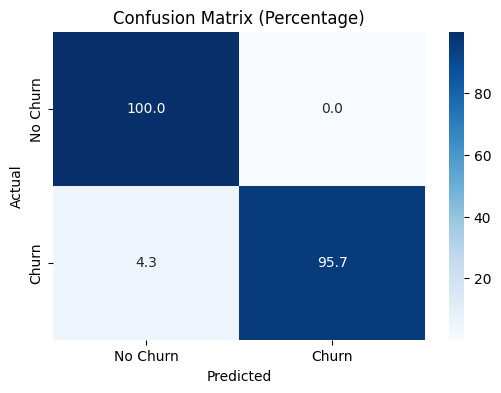

In [12]:
y_pred = best_rf.predict(x_test)
print('\nClassification Report:\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis] * 100  # Normalize to percentages
plt.figure(figsize=(6, 4))
sns.heatmap(cm_norm, annot=True, fmt='.1f', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
plt.savefig('confusion_matrix.png')
plt.show()

9. Checking for Overfitting

In [13]:
y_pred_train = best_rf.predict(x_train)
print('\nTraining Classification Report:\n', classification_report(y_train, y_pred_train))
print('\nTraining Confusion Matrix:\n', confusion_matrix(y_train, y_pred_train))
print(f"Training Accuracy: {best_rf.score(x_train, y_train):.2f}")
print(f"Test Accuracy: {best_rf.score(x_test, y_test):.2f}")


Training Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97    152742
         1.0       1.00      0.96      0.98    199923

    accuracy                           0.98    352665
   macro avg       0.97      0.98      0.98    352665
weighted avg       0.98      0.98      0.98    352665


Training Confusion Matrix:
 [[152742      0]
 [  8710 191213]]
Training Accuracy: 0.98
Test Accuracy: 0.98


10. Data Visualization: Precision-Recall Curve

In [14]:
y_scores = best_rf.predict_proba(x_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.', label=f'AUC = {pr_auc:.2f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.savefig('precision_recall_curve.png')
plt.show()

NameError: name 'auc' is not defined

11. Data Visualization: Feature Importance

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': x_encoded.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:\n", feature_importance)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
for p in ax.patches:
    width = p.get_width()
    ax.text(width, p.get_y() + p.get_height()/2, f'{width:.4f}', ha='left', va='center')
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig('feature_importance.png')
plt.show()

12. Saving the Model

In [ ]:
joblib.dump(best_rf, 'random_forest_churn_model.pkl')
print('Model saved as random_forest_churn_model.pkl')